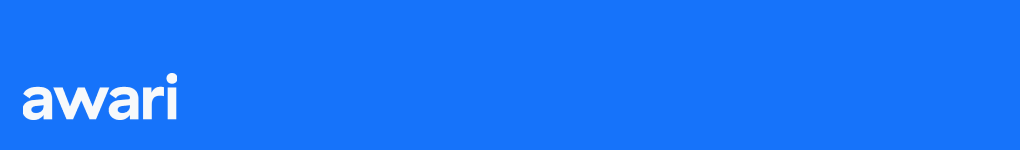

Prática da **Aula 15: Machine Learning IV**, do curso de **Data Science** da **[Awari](https://awari.com.br/)**. Para utilizá-la, vá no menu "Arquivo" e, em seguida, na opção "Salvar uma cópia no Drive". Isto criará uma cópia deste notebook em uma pasta chamada "Colab Notebooks", no seu Google Drive pessoal. Use a cópia para criar novas células de código ou executar as células desta prática.

---

# **Computer Vision com CNN**

## **Introdução**

**Computer Vision** ou CV é a área de Deep Learning que se ocupa com a visão computacional, o reconhecimento de imagens, objetos ou pessoas e temas relacionados.

**CNN**, por sua vez, é a sigla para *Convolutional Neural Network* (rede neural convolucional), um tipo de rede neural usado neste tipo de tarefa.

Par um entendimento mais intuitivo sobre CNNs, recomendamos [este artigo](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) da comunidade Towards Data Science.

### **Ativando GPUs no Colab**

Tarefas de CV normalmente demandam um alto poder computacional. Recomenda-se que seja acionado o uso de GPUs (Graphics Processing Units) aqui no Google Colab para uma perfomance melhor nesta prática.

Isto pode ser feito por meio do menu "Ambiente de Execução", submenu "Alterar o tipo de acelerador", selecionando-se a opção "GPU".

## **Começando a prática**

Com isso, podemos começar a prática. O primeiro passo, como sempre, é importar as bibliotecas que usaremos (são várias).

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
!pip install jovian --upgrade -q
import jovian

In [ ]:
project_name='cnn_test'

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

O conjunto de dados é extraído para o diretório data/cifar10. Ele contém 2 pastas (*train* e *test*, isto é, treino e teste, respectivamente), contendo o conjunto de treino (50.000 imagens) e o conjunto de teste (10.000 imagens), respectivamente. Cada uma delas contém 10 pastas, uma para cada classe de imagens.

In [ ]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('Número de exemplos de treinamento da classe:', len(airplane_files))
print(airplane_files[:5])

In [ ]:
ship_files = os.listdir(data_dir + "/test/ship")
print("'Número de exemplos de treinamento da classe:", len(ship_files))
print(ship_files[:5])

A estrutura de diretórios acima (uma pasta por classe) é usada por muitos conjuntos de dados de visão computacional, e a maioria das bibliotecas de aprendizado profundo fornece utilitários para trabalhar com esses conjuntos de dados. Podemos usar a *ImageFolderclasse* do torchvision para carregar os dados como tensores PyTorch.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Vejamos um elemento de amostra do conjunto de dados de treinamento. Cada elemento é uma tupla, contendo um tensor de imagem e um rótulo. Como os dados consistem em imagens coloridas de 32x32 px com 3 canais (RGB), cada tensor de imagem tem a forma (3, 32, 32).

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img
print(dataset.classes)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Podemos visualizar a imagem usando matplotlib, mas precisamos alterar as dimensões do tensor para (32,32,3). Vamos criar uma função auxiliar para exibir uma imagem e seu rótulo.

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [ ]:
show_example(*dataset[0])

In [ ]:
show_example(*dataset[1099])

Ao construir modelos de aprendizado de máquina do mundo real, é bastante comum dividir o conjunto de dados em 3 partes:

1. **Conjunto de treinamento:** usado para treinar o modelo, ou seja, calcular a perda e ajustar os pesos do modelo usando gradiente descendente;

2. **Conjunto de validação:** usado para avaliar o modelo durante o treinamento, ajustar hiperparâmetros (taxa de aprendizado etc.) e escolher a melhor versão do modelo;

3. **Conjunto de teste:** usado para comparar diferentes modelos ou diferentes tipos de abordagens de modelagem e relatar a precisão final do modelo.

Como não há um conjunto de validação predefinido, podemos separar uma pequena parte (5.000 imagens) do conjunto de treinamento para ser usado como conjunto de validação.

Usaremos ```random_split``` para auxiliar a PyTorch fazer isso. Para garantir que sempre criamos o mesmo conjunto de validação, também definiremos uma semente para o gerador de números aleatórios.

In [ ]:
# Treinamento e validação
random_seed = 42
torch.manual_seed(random_seed);
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

A biblioteca ```jovian``` também fornece uma API simples para registrar parâmetros importantes relacionados ao conjunto de dados, treinamento do modelo, resultados etc. para fácil referência e comparação entre vários experimentos.

In [ ]:
  #jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

Agora podemos criar carregadores de dados para treinamento e validação, para carregar os dados em lotes



In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Podemos observar lotes de imagens do conjunto de dados usando o método ```make_grid``` de torchvision.

Cada vez que o código a seguir é executado, obtemos um bach diferente, pois o amostrador embaralha os índices antes de criar os lotes.

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [ ]:
show_batch(val_dl)

In [ ]:
#jovian.commit(project=cnn_test, environment=None)

## **Definindo o modelo**

Usaremos uma rede neural convolucional por meio da classe ```nn.Conv2d``` do PyTorch.

A convolução 2D é uma operação bastante simples: você começa com um *kernel*, que é simplesmente uma pequena matriz de pesos. Esse kernel "desliza" sobre os dados de entrada 2D, realizando uma multiplicação elemento a elemento com a parte da entrada em que está atualmente e, em seguida, somando os resultados em um único pixel de saída.

In [ ]:
def kernel(image, kernel):
    ri, ci = image.shape       # Dimensão da imagem
    rk, ck = kernel.shape      # Dimensão do Kernel
    ro, co = ri-rk+1, ci-ck+1  # Dimensão de saída
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [ ]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

kernel(sample_image, sample_kernel)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

Para imagens multicanal, um *kernel* diferente é aplicado a cada canal e as saídas são somadas em pixels.

* **Menos parâmetros:** um pequeno conjunto de parâmetros (o *kernel*) é usado para calcular as saídas de toda a imagem, de modo que o modelo tem muito menos parâmetros em comparação com uma camada totalmente conectada;
* **Esparsidade de conexões:** em cada camada, cada elemento de saída depende apenas de um pequeno número de elementos de entrada, o que torna os passes para frente e para trás mais eficientes;
* **Compartilhamento de parâmetros e invariância espacial:** os recursos aprendidos por um kernel em uma parte da imagem podem ser usados ​​para detectar padrões semelhantes em uma parte diferente de outra imagem.

Também usaremos camadas de *pool* máximo para diminuir progressivamente a altura e a largura dos tensores de saída de cada camada convolucional.

Antes de definir todo o modelo, vamos ver como uma única camada convolucional seguida por uma camada *max-pooling* opera nos dados.

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

A camada ```Conv2d``` transforma uma imagem de 3 canais em um mapa de recursos de 16 canais e a MaxPool2dcamada divide a altura e a largura pela metade.

O mapa de recursos fica menor à medida que adicionamos mais camadas, até que finalmente ficamos com um pequeno mapa de recursos, que pode ser achatado em um vetor.

Podemos então adicionar algumas camadas totalmente conectadas no final para obter um vetor de tamanho 10 para cada imagem.

Vamos definir o modelo estendendo uma `ImageClassificationBaseclasse`, que contém métodos auxiliares para treinamento e validação.

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Gera predições
        loss = F.cross_entropy(out, labels) # Calcula perca
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Gera predições
        loss = F.cross_entropy(out, labels)   # Calcula Perca
        acc = accuracy(out, labels)           # Calcula Acurácia
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina a perca entre as camadas
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina a acurácia entre as camadas
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

Usaremos `nn.Sequential` para encadear as camadas e funções de ativação em uma única arquitetura de rede.



In [ ]:
model = Cifar10CnnModel()
model

Vamos verificar se o modelo produz a saída esperada em um lote de dados de treinamento.

As 10 saídas para cada imagem podem ser interpretadas como probabilidades para as 10 classes alvo (após a aplicação do *softmax*), e a classe com maior probabilidade é escolhida como o rótulo previsto pelo modelo para a imagem de entrada.

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [ ]:
def gpu_validate():
    """Ultiliza a GPU se disponível"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move o tensor para o hardware escolhido"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Envolve os dados para envia-lo para o harware"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Geração de batch e envio para o hardware (cpu/gpu)"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Número de batchs"""
        return len(self.dl)

Agora podemos agrupar nossos carregadores de dados de treinamento e validação usando `DeviceDataLoaderpara` transferir automaticamente lotes de dados para a GPU (se disponível).





In [ ]:
device = gpu_validate()
device

Em seguida, podemos agrupar nossos carregadores de dados de treinamento e validação usando `DeviceDataLoader` para transferir automaticamente lotes de dados para a GPU (se disponível) e usar `to_device` para mover nosso modelo para a GPU (se disponível).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

Vamos definir duas funções: `fit` e `evaluate`. Treinaremos o modelo usando gradiente descendente e avaliaremos seu desempenho no conjunto de validação.

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validação
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)
evaluate(model, val_dl)

A precisão inicial é de cerca de 10%, que é o que se poderia esperar de um modelo inicializado aleatoriamente (já que ele tem uma chance de 1 em 10 de acertar um rótulo de forma aleatória).

Usaremos os seguintes hiperparâmetros (taxa de aprendizado, número de épocas, *batch_size* etc.) para treinar nosso modelo:

In [ ]:
#Instâncias do treinamento
#num_epochs = 10
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Acurácia vs. Número de épocas');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(['Treinamento', 'Validação'])
    plt.title('Perda vs. número de épocas');
plot_losses(history)

## **Testando o modelo**

Utilizando a primeira imagem do dataset:

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Podemos escolher outra imagem da amostra modificando o ponteiro do dataset:

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
img, label = test_dataset[5]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

Atingimos uma acurácia de 70% no treinamento. Para entender mais sobre métricas, recomendamos a leitura [deste artigo](https://analyticsindiamag.com/loss-functions-in-deep-learning-an-overview/#:~:text=Neural%20Network%20uses%20optimising%20strategies,bad%20the%20model%20is%20performing).

---

Notebook utilizado para fins educacionais da **Awari**.

**© AWARI. Todos os direitos reservados.**